# Applying SDDR on KORA_S3_S4

We start by importing the sddr module and other required libraries:

In [6]:
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from sddr import Sddr
from sklearn.model_selection import train_test_split
import inspect
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#  A Simple GAM Gaussian Distribution

### User inputs 

First the user defines the data to be used:

In [7]:
# define data location and read data into pandas dataframe
data_path = '../../../Data/KORA_S3_S4/KORA_Noise_noMissing_median.csv'
KORA_Noise_noMissing = pd.read_csv(data_path)

data = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]
print(data.head())
print(data.describe())

target = KORA_Noise_noMissing['bp_syst']
print(target.head())
print(target.describe())

# split the data into train and test to use later for predictions
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2)


   sex   age    bmi  smoking  lden_org
0  0.0  31.0  18.94      2.0      41.0
1  1.0  40.0  27.14      2.0      55.2
2  1.0  59.0  30.34      3.0      55.2
3  0.0  62.0  19.46      1.0      46.8
4  0.0  62.0  31.25      2.0      51.2
               sex          age          bmi      smoking     lden_org
count  9116.000000  9116.000000  9116.000000  9116.000000  9116.000000
mean      0.492979    49.555836    27.115082     2.169263    54.721117
std       0.499978    14.033439     4.594119     0.810235     6.587108
min       0.000000    24.000000    15.840000     1.000000    15.600000
25%       0.000000    37.000000    23.940000     1.000000    50.600000
50%       0.000000    50.000000    26.580000     2.000000    53.900000
75%       1.000000    61.000000    29.630000     3.000000    58.500000
max       1.000000    75.000000    56.930000     3.000000    77.500000
0    106.0
1    143.0
2    164.0
3    109.0
4    113.0
Name: bp_syst, dtype: float64
count    9116.000000
mean      130.545470


Next the distribution, formulas and training parameters are defined. <b> The neural netowrks here are not expected to truly contribute to the networks performance as our data includes only structured data. </b> However, they are given in the formula for the user to understand the full power of the PySDDR package.  

In [41]:
# define distribution and the formula for the distibutional parameter
distribution  = 'Normal'
formulas = {'loc': '~1+spline(age, bs="bs",df=9)+spline(bmi, bs="bs",df=9)+d1(age)+d2(bmi)',
            'scale': '~1'}

# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 1000,
    'epochs': 200,
    'degrees_of_freedom': {'rate': 6},
    'optimizer' : optim.RMSprop,
    'val_split': 0.1
    }

# define output directory
output_dir = './outputs'

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [42]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

Using device:  cpu


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training

The sddr network is trained with the data defined above and the loss curve is plotted. Note that in this example we only have tabular data so unstructured_data is not given.

In [44]:
sddr.train(structured_data=train_data, target=train_target, plot=True)

ATTENTION! File format for data and target needs to be the same.


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'loc'

### Visualizing the partial effects

The partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

In the case below the model is a generalized additive model with two splines (one has a quadratic effect, one has only a linear effect), while target is assumed to come from a Poisson distribution. The quadratic and linear effects are confirmed when plotting the partial effects below.

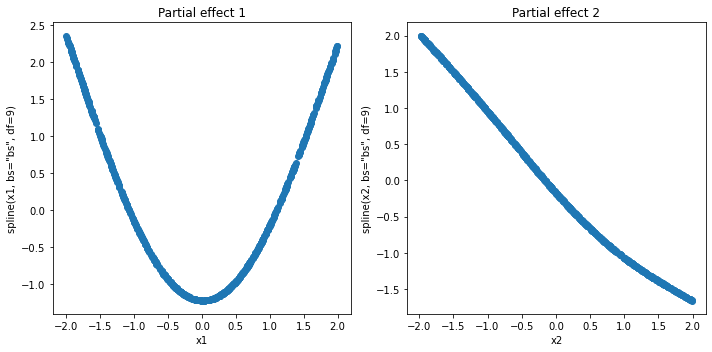

In [7]:
partial_effects = sddr.eval('rate')

### Save, load and resume

Next, we save the trained model. Along with the model's weights, the optimizer current state will be saved, along with the number of epochs we trained for and the final loss function

In [8]:
sddr.save('model_gam.pth')

<ipython-input-8-38575ea38e67>:1: UserWarning: Please note that the metadata for the structured input has not been saved. If you want to load the model and use
        it on new data you will need to also give the structured data used for training as input to the load function.
  sddr.save('model_gam.pth')


To resume training at a later state we need to again initialize an sddr instance, load the previously trained model and resume training. Note that the ```resume=True``` flag needs to be set here when calling ```sddr.train```. Also note that here ```epochs``` is set to 300, while previously the network was trained for ```200``` epochs. This means that the model during resume will train for 300-200=100 epochs more

In [9]:
train_parameters['epochs'] = 300
sddr_resume = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)
sddr_resume.load('./outputs/model_gam.pth', train_data)
sddr_resume.train(target=train_target, structured_data=train_data, resume=True)
loss_resume = sddr_resume.epoch_train_loss

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a validation loss of 9.4883
Beginning training ...
Train Epoch: 210 	 Training Loss: 9.588140
Train Epoch: 210 	 Validation Loss: 9.010602
Train Epoch: 240 	 Training Loss: 9.204211
Train Epoch: 240 	 Validation Loss: 8.646177
Train Epoch: 270 	 Training Loss: 8.985331
Train Epoch: 270 	 Validation Loss: 8.404903


### Predicting

A trained model can also be used for predictions on unseen data. Note that when loading the model the structured training data is required to compute the knots of the basis functions used for the smoothing terms. The final line in this cell is commented out as it would give an error if run. Why? Check out the explanation below!

In [10]:
# initialize
pred_sddr = Sddr(distribution=distribution,
                formulas=formulas,
                deep_models_dict=deep_models_dict,
                train_parameters=train_parameters,
                output_dir=output_dir)
# load trained model
pred_sddr.load('./outputs/model_gam.pth', train_data)
# make predictions
#_, partial_effects_loaded = pred_sddr.predict(test_data, plot=True)

Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a validation loss of 9.4883


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The above error occurs because the test data is outside the range of the training data. The framework can deal with this problem by allowing clipping of the test data. For clipping the corresponding parameter needs to be set to ```True``` when calling ```predict()```

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


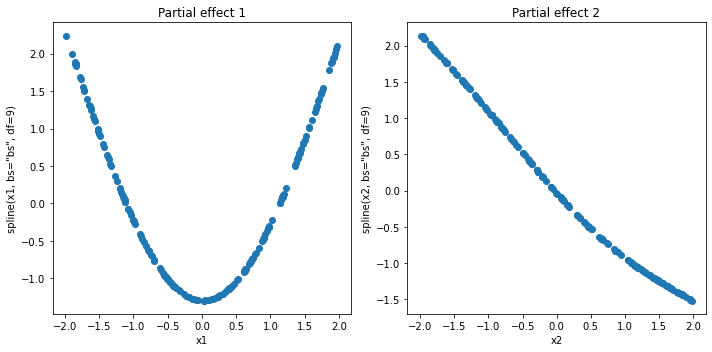

In [11]:
_, partial_effects_loaded = pred_sddr.predict(test_data, clipping=True, plot=True)

### Predicted Distribution

To get the distribution simply call:

In [12]:
distribution_layer = pred_sddr.get_distribution()

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From there we can retrieve many of the distribution's properties. See some examples here:

In [13]:
mean = distribution_layer.mean
std = distribution_layer.stddev

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Second use case: GAMLSS - Logistic Distribution

In this example the input data follows a logistic distribution. Therefore, here we have two distributional parameters, which means that two fomulas need to be defined (which in turn means two SDDRFormulaNets will be created). Additinaly degrees of freedom for the regularization of the loss need to be given for each distributional parameter

### User inputs 

Once again first the user defines the data to be used. Note that this time we are not pre-loading the data as a pandas dataframe, but will give the framework directly the data paths:

In [19]:
data_path = '../data/gamlss/X.csv'
target_path = '../data/gamlss/Y.csv'

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next the distribution, formulas and training parameters are defined. Note that PySDDR also support batching: in this example a batch size smaller than the size of the data is defined.

In [20]:
distribution  = 'Logistic'

formulas = {'loc': '~1+spline(x1, bs="bs", df=4)+spline(x2, bs="bs",df=4) + d1(x1)+d2(x2)',
            'scale': '~1 + spline(x3, bs="bs",df=4) + spline(x4, bs="bs",df=4)'
            }

deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

train_parameters = {
    'batch_size': 100,
    'epochs': 1000,
    'degrees_of_freedom': {'loc': [5,5], 'scale':[5,10]},
    'optimizer' : optim.RMSprop,
    'val_split': 0.15,
    'early_stop_epochs': 100,
    'early_stop_epsilon': 0.0001
}

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note that in the training parameters defined above we have also included early stopping parameters. In this case training will stop (before the 1000 epochs defined) if the validation loss is not dropping by more than 10e-4 for 100 epochs. 

### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step. This time we do not specify an output directory which means all outputs will be stored in the current working directory.

In [21]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)

Using device:  cpu


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training

Again in this example we train our network with our training data


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\sddr\utils\utils.py:320: UserWarning: df too large: Degrees of freedom (df = 5) cannot be larger than the rank of the design matrix (rank = 4). 
            Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  df_lam = df2lambda(dm_spline, P[0], df)
C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\sddr\utils\utils.py:320: UserWarning: df too large: Degrees of freedom (df = 5) cannot be larger than the rank of the design matrix (rank = 4). 
            Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  df_lam

Beginning training ...
Train Epoch: 0 	 Training Loss: 2.669543
Train Epoch: 0 	 Validation Loss: 2.410011
Train Epoch: 100 	 Training Loss: 2.317044
Train Epoch: 100 	 Validation Loss: 2.177330
Train Epoch: 200 	 Training Loss: 2.316788
Train Epoch: 200 	 Validation Loss: 2.175212
Train Epoch: 300 	 Training Loss: 2.316785
Train Epoch: 300 	 Validation Loss: 2.175171
Validation loss has not improved for the last 100 epochs! To avoid overfitting we are going to stop training now


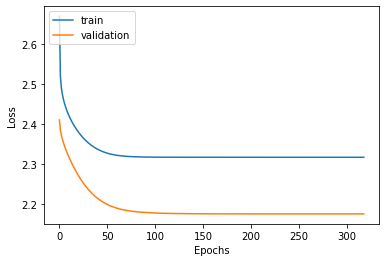

In [17]:
#instead of giving a data and target as data frames, here we give the path and the data is loaded automatically
sddr.train(structured_data=data_path,
           target=target_path,
           plot=True)

Note that when using early stopping the training stops after about 150 epochs. This helps avoid overfitting and we can also see from the loss plots that the model has converged and overfitting has been avoided (the validation loss is not much larger than the training loss). This means that the choice of hyperparameters for early stopping was correct. 

### Visualizing the partial effects

In this case the model is a generalized additive model with:

* two splines: one has a quadratic effect, one has only a linear effect for the mean ('loc') parameter 
* two splines: one has only a linear effect with slope 0.5, one has the form sin(4*x)) for the scale parameter.

 These effects are confirmed when plotting the partial effects below.

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


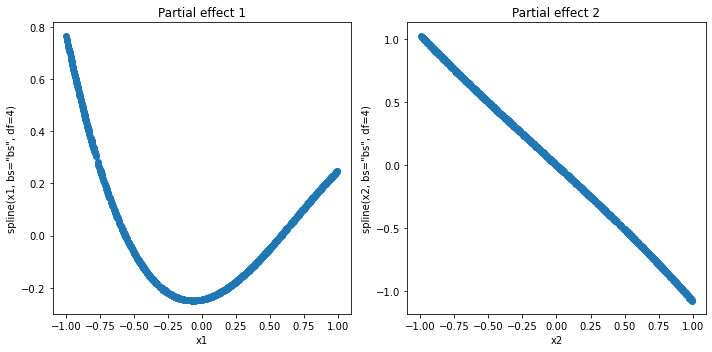

In [18]:
partial_effects_loc = sddr.eval('loc')

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


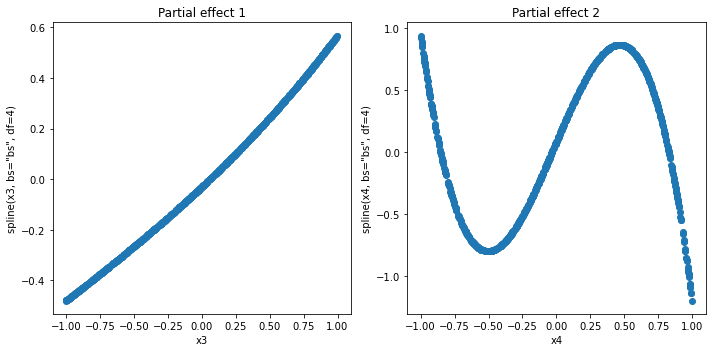

In [19]:
partial_effects_scale = sddr.eval('scale')

### Orthogonalization

As explained in the readme the model in pysddr has two orthogonalization steps that work in a similar manner: 

1. Orthogonalization between linear and smooth terms to remove any linear effects from smooth terms and leave only non-linear features (performed during pre-processing) and
2. Orthogonalization between smooth terms and unstructured outputs to remove any effects from smooth terms in unstructured part (performed during every forward pass of the network)

To visualize the effect of orthogonalization, in the example below we change the formulas from above and add the linear feature x3 to the linear part of the scale formula. We then re-train our model based on the new formula and visualize the partial effects.

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\sddr\utils\utils.py:320: UserWarning: df too large: Degrees of freedom (df = 5) cannot be larger than the rank of the design matrix (rank = 4). 
            Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  df_lam = df2lambda(dm_spline, P[0], df)
C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\sddr\utils\utils.py:320: UserWarning: df too large: Degrees of freedom (df = 5) cannot be larger than the rank of the design matrix (rank = 4). 
            Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  df_lam

Using device:  cpu
Beginning training ...
Train Epoch: 0 	 Training Loss: 2.676135
Train Epoch: 0 	 Validation Loss: 2.621061
Train Epoch: 100 	 Training Loss: 2.267893
Train Epoch: 100 	 Validation Loss: 2.358178
Validation loss has not improved for the last 100 epochs! To avoid overfitting we are going to stop training now


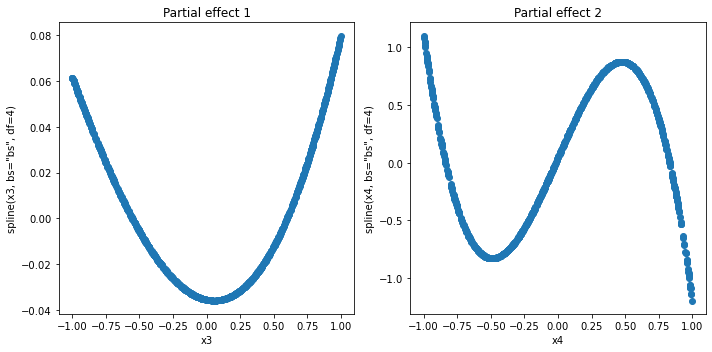

In [20]:
formulas = {'loc': '~1+spline(x1, bs="bs", df=4)+spline(x2, bs="bs",df=4) + d1(x1)+d2(x2)',
            'scale': '~x3 + spline(x3, bs="bs",df=4) + spline(x4, bs="bs",df=4)'
            }
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)

sddr.train(structured_data=data_path,
           target=target_path)

partial_effects_scale = sddr.eval('scale')

As expected the orthogonalization has removed the effect of feature x3 (Partial effect 1) from the smooth terms as it is a linear feature which can be fully represented by the linear part of the network. The values in the y-axis are so small resulting in this partial effect actually having little or no effect. In addition, we can check the linear effects using the coef function to see if the actual linear effect is recovered well.

In [21]:
sddr.coeff('scale')

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Intercept': array([0.2659301], dtype=float32),
 'x3': array([0.5184814], dtype=float32),
 'spline(x3, bs="bs", df=4)': array([ 0.31428796,  0.02331932, -0.20998375, -0.2180218 ], dtype=float32),
 'spline(x4, bs="bs", df=4)': array([ 0.7215684, -4.9826283,  4.3750777, -1.5745573], dtype=float32)}